In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
import os
from keras.callbacks import TensorBoard
from keras import backend as be
import time

Using TensorFlow backend.


In [0]:
import sys
import sklearn
import numpy as np
try:
    %tensorflow_version 2.x
except Exception:
    pass
    
import tensorflow as tf
import os
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving image", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Get Data Cifar10

In [3]:
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
img_width, img_height = 32, 32

(input_train, target_train), (input_test, target_test) = cifar10.load_data()
print(input_train.shape[0], 'train:')
print(input_test.shape[0], 'test:')

50000 train:
10000 test:


Convert labels to binary

In [0]:
target_train = keras.utils.to_categorical(target_train, num_classes)
target_test = keras.utils.to_categorical(target_test, num_classes)

Make numbers float

In [0]:
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

Scale

In [0]:
input_train = input_train / 255
input_test = input_test / 255

Create Model

In [0]:
def create_model():
  model = Sequential()
  model.add(Flatten(input_shape = (32,32,3)))
  model.add(Dense(600, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01), kernel_initializer= 'he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(300, activation='elu', kernel_regularizer= keras.regularizers.l2(0.01), kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(100, activation='relu', kernel_regularizer= keras.regularizers.l2(0.01), kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(num_classes, activation='softmax', kernel_regularizer= keras.regularizers.l2(0.01), kernel_initializer='he_uniform'))

  # Compile the model
  opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model

TensorBoard

In [8]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6009

root_logdir = os.path.join(os.curdir, "logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

Reusing TensorBoard on port 6009 (pid 584), started 0:19:35 ago. (Use '!kill 584' to kill it.)

<IPython.core.display.Javascript object>

Train

In [9]:
# custom callback: print valdation ratio
class PrintTrainValRatioCb(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))


model = create_model()

datagen = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1, 
                             horizontal_flip=True)

print (model.summary())

# callbacks: checkpoint, early stopping, tensorboard
filepath = "cifar10.hdf5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath, 
                                            save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,   
                                      restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
train_val_ratio_cb = PrintTrainValRatioCb()
reduce_lr_cb = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

history = model.fit_generator(datagen.flow(input_train, target_train,
                    batch_size=batch_size), epochs= 50,
                    validation_data=(input_test, target_test),
                    workers=4,
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb,
                               train_val_ratio_cb,
                               tensorboard_cb
                               ])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               1843800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 600)               2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               180300    
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)              

Evaluate on test set

In [10]:
scores = model.evaluate(input_test, target_test, verbose=1, callbacks = [keras.callbacks.TensorBoard(run_logdir)])
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 105us/step
Test loss: 1.5308508937835694
Test accuracy: 0.48089998960494995


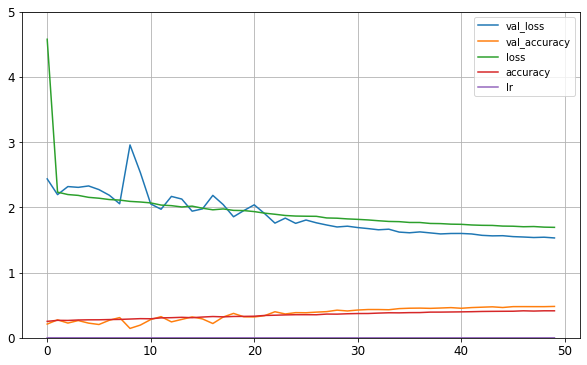

In [11]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()